# OCO-2 Data Access and Quick Aggregation

## Author: Jon Hobbs
## Date Authored: 1-18-24

This notebook provides a quick demonstration on accessing and summarizing products from the Orbiting Carbon Observatory-2 (OCO-2) hosted via an Amazon S3 bucket. It demonstrates how to access an S3 bucket with the S3FS library, how to read data with xarray, and how to quickly compute and plot small-area aggregate estimates of atmospheric carbon dioxide.

## Import Libraries and Set Up CMR

In [1]:
import requests

def cmr_request(params):
    response = requests.get(url,
                        params=params,
                        headers={
                            'Accept': 'application/json',
                        }
                       )
    return response


## Obtain S3 URLs

This notebook works with OCO-2 data in a one-month block. The relevant datasets are available at daily resolution



In [3]:
url = 'https://cmr.earthdata.nasa.gov/search/granules'

short_name = 'OCO2_L2_Lite_FP'

start_time = '2020-05-01T00:00:00Z'
end_time = '2020-06-01T00:00:00Z'
mthstr = 'LtCO2_2005'

# OPTION 1: Using shortname
response = cmr_request({
                        'short_name': short_name,
                        'temporal': start_time+','+end_time,
                        'version': '11.1r',
                        'page_size': 200
                        })


granv11 = response.json()['feed']['entry']
s3_urls_v11 = []
for granule in granv11:
    for item in granule['links']:
        if ( (item["href"].startswith("s3://")) and (mthstr in item["href"]) ):
            s3_urls_v11.append(item["href"])


In [4]:
s3_urls_v11

['s3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2020/oco2_LtCO2_200501_B11100Ar_230603205508s.nc4',
 's3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2020/oco2_LtCO2_200502_B11100Ar_230603205609s.nc4',
 's3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2020/oco2_LtCO2_200503_B11100Ar_230603205614s.nc4',
 's3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2020/oco2_LtCO2_200504_B11100Ar_230603205837s.nc4',
 's3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2020/oco2_LtCO2_200505_B11100Ar_230603205850s.nc4',
 's3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2020/oco2_LtCO2_200506_B11100Ar_230603205935s.nc4',
 's3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2020/oco2_LtCO2_200507_B11100Ar_230603210045s.nc4',
 's3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2020/oco2_LtCO2_200508_B11100Ar_230603210103s.nc4',
 's3://gesdisc-cumulus-p

## Open files and aggregate

Load additional libraries and obtain S3 credentials

In [5]:
from netrc import netrc
from subprocess import Popen
from platform import system
from getpass import getpass
import os
import requests
import xarray as xr
import s3fs
import boto3



In [6]:
gesdisc_s3 = "https://data.gesdisc.earthdata.nasa.gov/s3credentials"

# Define a function for S3 access credentials

def begin_s3_direct_access(url: str=gesdisc_s3):
    response = requests.get(url).json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],
                             secret=response['secretAccessKey'],
                             token=response['sessionToken'],
                             client_kwargs={'region_name':'us-west-2'})

fs = begin_s3_direct_access()

# Check that the file system is intact as an S3FileSystem object, which means that token is valid
# Common causes of rejected S3 access tokens include incorrect passwords stored in the netrc file, or a non-existent netrc file
type(fs)

s3fs.core.S3FileSystem

In [7]:
fs.info(s3_urls_v11[0])

{'ETag': '"40909822f73e68993433907dd24c4614-1"',
 'LastModified': datetime.datetime(2023, 6, 29, 17, 17, 44, tzinfo=tzutc()),
 'size': 54991458,
 'name': 'gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2020/oco2_LtCO2_200501_B11100Ar_230603205508s.nc4',
 'type': 'file',
 'StorageClass': 'STANDARD',
 'VersionId': None,
 'ContentType': 'binary/octet-stream'}

### Loop Through Files

* Loop through each daily file
* Extract XCO2, raw XCO2, quality flag, surface type
* Aggregate to 10s average



In [8]:
import pandas
import numpy

def qsummary(df,grpvr,vrlst):
    # Summarize with quantiles
    nmtch = df.shape[0] 
    dfout = pandas.DataFrame({'NSmp' : nmtch}, index=[0])
    #dfout[grpvr] = df[grpvr].values[0]
    for j in range(len(vrlst)):
        tmpdt = df[vrlst[j]]
        dtvld = tmpdt[numpy.isfinite(tmpdt)]
        dtvld = dtvld[dtvld != 0.0]
        vrnm = '%s_Med' % (vrlst[j])
        dfout[vrnm] = numpy.median(dtvld)

    return dfout



In [9]:
nbtch = 0

for k in range(len(s3_urls_v11)): 
    print(s3_urls_v11[k])
    ltnc = xr.open_dataset(fs.open(s3_urls_v11[k]),
                           decode_cf=True,)
    ltsdg = ltnc.sounding_id.values[:]
    ltlat = ltnc.latitude.values[:]
    ltlon = ltnc.longitude.values[:]
    ltxco2 = ltnc.xco2.values[:]
    ltflg = ltnc.xco2_quality_flag[:]
    ltnc.close()

    ltncrtr = xr.open_dataset(fs.open(s3_urls_v11[k]),
                              decode_cf=True,group="Retrieval")
    xco2rw = ltncrtr.xco2_raw.values[:]
    sfctp = ltncrtr.surface_type.values[:]
    ltncrtr.close()
    # Surface type: 0=water, 1=land

    ltfrm = pandas.DataFrame({'SoundingID': ltsdg, 
                          'Latitude': ltlat, 'Longitude': ltlon, 'XCO2': ltxco2, 'XCO2Raw': xco2rw,
                          'V11QFlag': ltflg, 'SfcType':sfctp})
    ltfrm['Sdg10s'] = numpy.floor(ltfrm['SoundingID'] / 1.0e3)
    ltfrm = ltfrm[ltfrm['V11QFlag'] == 0]
    
    grpoco = ltfrm.groupby(['Sdg10s','SfcType'])
    ocoqs = grpoco.apply(qsummary,grpvr='Sdg10s',vrlst=['XCO2','XCO2Raw','Latitude','Longitude'])
    ocoqs.reset_index(drop=False,inplace=True)    
    
    print(ocoqs.shape)
    
    if nbtch == 0:
        oco_all = ocoqs
    else:
        oco_all = pandas.concat([oco_all,ocoqs], ignore_index=True) 
    nbtch = nbtch + ocoqs.shape[0]

s3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2020/oco2_LtCO2_200501_B11100Ar_230603205508s.nc4
(1003, 8)
s3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2020/oco2_LtCO2_200502_B11100Ar_230603205609s.nc4
(1124, 8)
s3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2020/oco2_LtCO2_200503_B11100Ar_230603205614s.nc4
(1154, 8)
s3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2020/oco2_LtCO2_200504_B11100Ar_230603205837s.nc4
(968, 8)
s3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2020/oco2_LtCO2_200505_B11100Ar_230603205850s.nc4
(852, 8)
s3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2020/oco2_LtCO2_200506_B11100Ar_230603205935s.nc4
(1091, 8)
s3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2020/oco2_LtCO2_200507_B11100Ar_230603210045s.nc4
(922, 8)
s3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2020/oco2_LtCO2_200508_B11100Ar_2306032

In [10]:
nbtch

32217

In [11]:
oco_all[100:110]

,Sdg10s,SfcType,level_2,NSmp,XCO2_Med,XCO2Raw_Med,Latitude_Med,Longitude_Med
100,2.020050e+12,0.0,0,98,409.639709,408.697479,-26.459198,179.931015
101,2.020050e+12,0.0,0,1,410.275116,409.971375,-25.017172,179.572281
102,2.020050e+12,0.0,0,4,410.071075,409.841553,-24.642244,179.567856
103,2.020050e+12,0.0,0,192,409.660583,408.879517,-24.109816,179.448166
104,2.020050e+12,0.0,0,159,409.596741,408.750000,-23.617317,179.331955
105,2.020050e+12,0.0,0,57,409.575500,408.372131,-23.199471,179.233887
106,2.020050e+12,0.0,0,9,409.456116,407.841705,-22.288710,179.085449
107,2.020050e+12,0.0,0,1,409.373810,408.491486,-21.715818,178.902206
108,2.020050e+12,0.0,0,17,409.430115,408.188171,-21.298992,178.869934
109,2.020050e+12,0.0,0,10,409.515930,408.344055,-20.984327,178.771576


### Summarize by Latitude

Further aggreagtion of results by latitude bins and surface type

In [12]:
# Subset by sounding count
oco_all = oco_all[oco_all['NSmp'] > 30]
oco_all['XCO2Diff'] = oco_all['XCO2Raw_Med'] - oco_all['XCO2_Med']

# Latitude binning
ltfrq = 15.0
oco_all['GridLat'] = numpy.floor(oco_all['Latitude_Med']/ltfrq) * ltfrq + ltfrq / 2.0

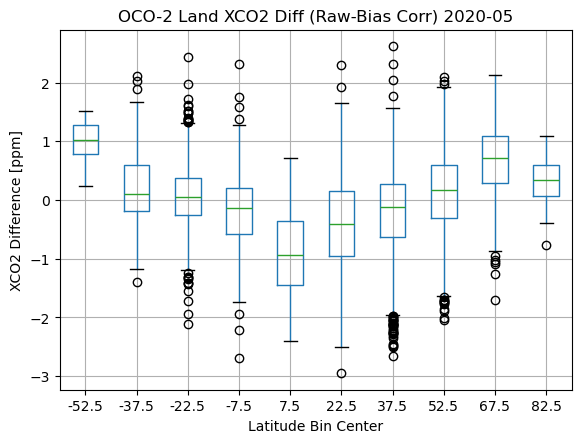

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

# Land Only
oco_lnd = oco_all[ oco_all['SfcType'] == 1]

lndbx = oco_lnd.boxplot(column=['XCO2Diff'], by=['GridLat'])
lndbx.plot()
lndbx.get_figure().suptitle("")
plt.title('OCO-2 Land XCO2 Diff (Raw-Bias Corr) 2020-05')
plt.ylabel('XCO2 Difference [ppm]')
plt.xlabel('Latitude Bin Center')
plt.show()

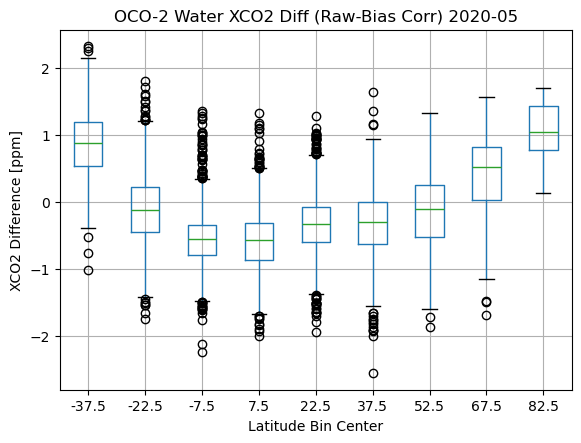

In [14]:
# Water Only
oco_wtr = oco_all[ oco_all['SfcType'] == 0]

wtrbx = oco_wtr.boxplot(column=['XCO2Diff'], by=['GridLat'])
wtrbx.plot()
wtrbx.get_figure().suptitle("")
plt.title('OCO-2 Water XCO2 Diff (Raw-Bias Corr) 2020-05')
plt.ylabel('XCO2 Difference [ppm]')
plt.xlabel('Latitude Bin Center')
plt.show()